<a href="https://colab.research.google.com/github/Galiishaq/uni_project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [18]:
# Load the data
file_path = '/content/MY OWN.xlsx'
data = pd.read_excel(file_path)

# Set date as index
data.set_index('DATE', inplace=True)
data

,ADMISSION,DISCHARGE,BED_OCCUPANCY
DATE,,,
2023-01-01,12,13,43
2023-01-02,16,12,46
2023-01-03,11,12,45
2023-01-04,9,9,42
2023-01-05,9,8,42
...,...,...,...
2023-12-27,10,12,34
2023-12-28,12,9,34
2023-12-29,13,19,38


In [19]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Convert the scaled data to a DataFrame
scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)
scaled_data

,ADMISSION,DISCHARGE,BED_OCCUPANCY
DATE,,,
2023-01-01,0.357143,0.321429,0.394366
2023-01-02,0.500000,0.285714,0.436620
2023-01-03,0.321429,0.285714,0.422535
2023-01-04,0.250000,0.178571,0.380282
2023-01-05,0.250000,0.142857,0.380282
...,...,...,...
2023-12-27,0.285714,0.285714,0.267606
2023-12-28,0.357143,0.178571,0.267606
2023-12-29,0.392857,0.535714,0.323944


In [20]:
# Function to create sequences
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequence = data.iloc[i:i + sequence_length].values
        target = data.iloc[i + sequence_length].values[2]  # BED_OCCUPANCY is the target
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [21]:
# Define the sequence length
sequence_length = 7

# Create sequences and targets
sequences, targets = create_sequences(scaled_data, sequence_length)

In [25]:
# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(len(sequences) * split_ratio)

X_train, X_test = sequences[:split_index], sequences[split_index:]
y_train, y_test = targets[:split_index], targets[split_index:]

In [26]:
# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 3)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

In [32]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.1)

# Evaluate the model on the test data
loss = model.evaluate(X_test, y_test)

print(f'Test Loss: {loss}')


Epoch 1/500
9/9 [==============================] - 6s 196ms/step - loss: 0.0054 - val_loss: 0.0040
Epoch 2/500
9/9 [==============================] - 0s 24ms/step - loss: 0.0060 - val_loss: 0.0041
Epoch 3/500
9/9 [==============================] - 0s 22ms/step - loss: 0.0061 - val_loss: 0.0040
Epoch 4/500
9/9 [==============================] - 0s 19ms/step - loss: 0.0056 - val_loss: 0.0063
Epoch 5/500
9/9 [==============================] - 0s 13ms/step - loss: 0.0061 - val_loss: 0.0042
Epoch 6/500
9/9 [==============================] - 0s 13ms/step - loss: 0.0094 - val_loss: 0.0066
Epoch 7/500
9/9 [==============================] - 0s 13ms/step - loss: 0.0063 - val_loss: 0.0040
Epoch 8/500
9/9 [==============================] - 0s 13ms/step - loss: 0.0057 - val_loss: 0.0043
Epoch 9/500
9/9 [==============================] - 0s 13ms/step - loss: 0.0051 - val_loss: 0.0040
Epoch 10/500
9/9 [==============================] - 0s 14ms/step - loss: 0.0055 - val_loss: 0.0047
Epoch 11/500
9/9 [

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform predictions and true values to original scale
y_test_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), 2)), y_test.reshape(-1, 1)), axis=1))[:, 2]
y_pred_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred), 2)), y_pred), axis=1))[:, 2]

3/3 [==============================] - 1s 7ms/step


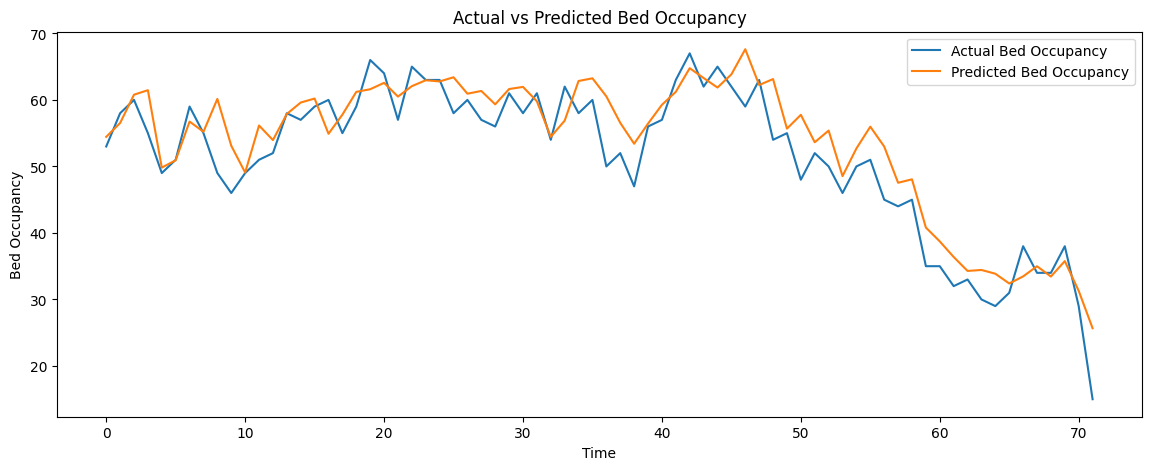

In [34]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 5))
plt.plot(y_test_inv, label='Actual Bed Occupancy')
plt.plot(y_pred_inv, label='Predicted Bed Occupancy')
plt.title('Actual vs Predicted Bed Occupancy')
plt.xlabel('Time')
plt.ylabel('Bed Occupancy')
plt.legend()
plt.show()

In [35]:
# Calculate performance metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')


Mean Absolute Error (MAE): 3.3534690613547937
Root Mean Squared Error (RMSE): 4.339368320799797
R-squared (R²): 0.844048029620247
